# Systematic impacts of word onsets on word concreteness

Do the sounds in a word impact its meaning? 

In [another notebook](http://localhost:8888/notebooks/concreteness_impacts.ipynb), I showed that the first character of a word *can* have predictable effects on its concreteness. Here, I repeat this analysis, but with phonetic representations of words (using [PhonDISC](http://groups.linguistics.northwestern.edu/speech_comm_group/documents/CELEX/Phonetic%20codes%20for%20CELEX.pdf)). 

In [1]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Operations
import numpy as np
import pandas as pd 
import statsmodels.formula.api as sm
from tqdm import tqdm

# Custom imports
from nlp_utilities.compling import CorpusUtilities
from src.utils import get_concreteness_for_word




In [6]:
# Set global variables
DATA_PATH = "data/raw/mrc_concreteness.csv"
CHARACTER_INDEX	= 0

# Get data
df = pd.read_csv(DATA_PATH, sep="\t")
df['Word'] = df['Word'].str.lower()

# Rescale concreteness
df['Concreteness'] = df['Concreteness'] / 100

# Drop duplicates
df = df.drop_duplicates(subset="Word")
print("Number of words left in MRC: {num}".format(num=len(df)))

# Merge with celex
df_celex = pd.read_csv("data/raw/celex_all.csv", sep = "\\")
df_celex = df_celex.drop_duplicates(subset='Word')
print("Number of words in CELEX: {num}".format(num=len(df_celex)))

# Merge together to get phonetic representations
df_merged = df_celex.merge(df, on="Word")
print("Number of words in both MRC and CELEX: {num}".format(num=len(df_merged)))

# Drop duplicate phonetic representations (homophones)
df_merged = df_merged.drop_duplicates(subset = 'PhonDISC')
print("Number of words left: {num}".format(num=len(df_merged)))



Number of words left in MRC: 4293
Number of words in CELEX: 46133
Number of words in both MRC and CELEX: 4136
Number of words left: 3947


In [7]:
# Take out multimorphemic words
df_merged = df_merged[df_merged['CompCnt'] <= 1]
df_merged.head(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness
0,a,4.36,1,1,ART,1,2.01
4,abbess,0.48,0,{bEs,N,2,4.01
6,abdomen,0.78,0,{bd@mEn,N,3,5.86
8,aberration,0.48,0,{b@r1SH,N,4,3.30
9,abhor,0.30,0,@bh$R,V,2,3.20


In [8]:
# Get minimal sets
print("Getting minimal sets...")
minimal_sets = CorpusUtilities.get_minimal_orthographic_sets(df_merged['PhonDISC'], index=CHARACTER_INDEX)
print("Number of minimal sets: {num}".format(num=len(minimal_sets)))

  0%|          | 11/2984 [00:00<00:28, 103.73it/s]

Getting minimal sets...


100%|██████████| 2984/2984 [00:44<00:00, 66.35it/s] 

Number of minimal sets: 380


In [9]:
# Calculate onset impact
onset_to_impact = []
for set_index, ms in tqdm(list(enumerate(minimal_sets))):
	letters = [w[CHARACTER_INDEX] for w in ms]
	by_word_cnc = get_concreteness_for_word(ms, df_merged, column='PhonDISC')
	mean_cnc = np.mean(by_word_cnc)
	for index, onset in enumerate(letters):
		to_add = [onset, by_word_cnc[index] - mean_cnc, mean_cnc, ms[index], set_index]
		onset_to_impact.append(to_add)

COLUMNS = ['onset', 'concreteness_impact', 'set_mean', 'original_word', 'set_index']
final_df = pd.DataFrame(onset_to_impact, columns=COLUMNS)



100%|██████████| 380/380 [00:01<00:00, 231.59it/s]


## Analysis

Now we look at whether particular onsets have systematic impacts on the concreteness of the words in which they appear.

In [11]:
result = sm.ols(formula="concreteness_impact ~ onset", data=final_df).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concreteness_impact   R-squared:                       0.082
Model:                             OLS   Adj. R-squared:                  0.055
Method:                  Least Squares   F-statistic:                     3.015
Date:                 Thu, 15 Nov 2018   Prob (F-statistic):           4.12e-09
Time:                         15:02:40   Log-Likelihood:                -1769.5
No. Observations:                 1317   AIC:                             3617.
Df Residuals:                     1278   BIC:                             3819.
Df Model:                           38                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1653      0.356     -0.464      0.642      -0.863       0.533
onset[T.$]    -0.3144      0.524     -0.600      0.548      -1.342       0.713
onset[T.1]    -0.2689      0.487     -0.552      0.581      -1.225       0.687
onset[T.2]     1.2057      0.590      2.043      0.041       0.048       2.363
onset[T.3]     0.7997      0.650      1.231      0.219      -0.475       2.074
onset[T.4]     0.8924      0.755      1.182      0.237      -0.588       2.373
onset[T.5]     0.2043      0.474      0.431      0.667      -0.726       1.135
onset[T.6]     0.1581      0.755      0.209      0.834      -1.323       1.639
onset[T.7]     1.7528      1.006      1.742      0.082      -0.222       3.727
onset[T.8]     0.5328      1.006      0.529      0.597      -1.442       2.507
onset[T.@]    -0.9839      0.755     -1.303      0.193      -2.465       0.497
onset[T.D]    -1.8833      0.464     -4.059      0.000      -2.794      -0.973
onset[T.E]     0.2090      0.590      0.354      0.723      -0.949       1.367
onset[T.I]    -0.0150      0.551     -0.027      0.978      -1.096       1.066
onset[T.J]     0.6309      0.411      1.535      0.125      -0.175       1.437
onset[T.Q]     0.5500      0.590      0.932      0.351      -0.608       1.708
onset[T.S]     0.3853      0.398      0.968      0.333      -0.395       1.166
onset[T.T]    -0.2151      0.404     -0.532      0.595      -1.008       0.578
onset[T.V]    -0.0931      0.524     -0.178      0.859      -1.121       0.934
onset[T._]     0.2020      0.396      0.509      0.611      -0.576       0.980
onset[T.b]     0.3649      0.368      0.993      0.321      -0.356       1.086
onset[T.d]     0.2364      0.375      0.630      0.529      -0.499       0.972
onset[T.f]     0.1138      0.369      0.308      0.758      -0.611       0.838
onset[T.g]     0.2381      0.380      0.627      0.531      -0.507       0.983
onset[T.h]     0.1026      0.372      0.276      0.783      -0.627       0.833
onset[T.i]     0.2051      0.524      0.392      0.695      -0.822       1.233
onset[T.j]     0.0604      0.436      0.138      0.890      -0.795       0.915
onset[T.k]     0.4914      0.367      1.338      0.181      -0.229       1.212
onset[T.l]     0.0567      0.373      0.152      0.879      -0.675       0.788
onset[T.m]    -0.0516      0.373     -0.138      0.890      -0.782       0.679
onset[T.n]    -0.1024      0.382     -0.268      0.789      -0.852       0.647
onset[T.p]     0.3245      0.369      0.880      0.379      -0.399       1.048
onset[T.r]     0.1897      0.372      0.510      0.610      -0.540       0.920
onset[T.s]     0.1251      0.370      0.338      0.736      -0.602       0.852
onset[T.t]     0.2554      0.371      0.688      0.492      -0.473       0.984
onset[T.v]     0.0600      0.409      0.147      0.883      -0.741    

In [12]:

### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 1000

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = final_df.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['onset'])
    new_result = sm.ols(formula="concreteness_impact ~ shuffled_onset", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 1000/1000 [00:17<00:00, 56.13it/s]


In [13]:
p_real = len([r for r in shuffled_rsquares if r >= true_rsquare]) / len(shuffled_rsquares)
print("p={p}".format(p=p_real))

p=0.0


Text(0.5,1,'Real R^2 vs. distribution from random permutations')

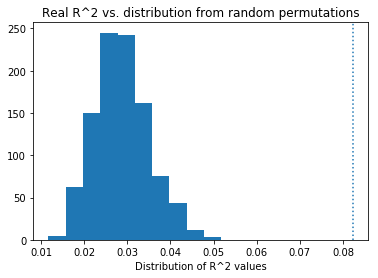

In [14]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Real R^2 vs. distribution from random permutations")

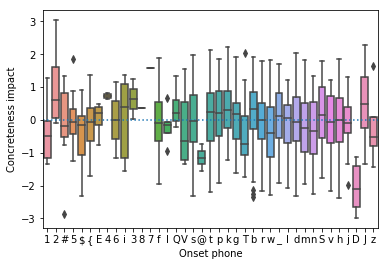

In [16]:
ax = sn.boxplot(data=final_df, x="onset", y="concreteness_impact")
ax.set(xlabel="Onset phone", ylabel="Concreteness impact")
ax.axhline(y=0, linestyle="dotted")

## Discussion and exploration

Based on these results, it seems like:

First, there is more structure in mappings between phonetic onsets and word concreteness than one would expect by chance, one we control for characteristics about the rest of the word.

Certain onsets exhibit particularly strong effects, such as: 
- **/D/** (the onset in *they*) has a consistently *negative* impact on concreteness.
- **/2/** (the onset in *aisle* or *eye*) has a consistently *positive* impact on concreteness.

Other onsets show trends, but not strongly significant trends.

In [17]:
df_merged['initial'] = df_merged['PhonDISC'].apply(lambda x: x[0])

In [18]:
df_merged[df_merged['initial'] == "D"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
3672,that,0.00,1,D{t,ADV,1,2.32,D
3670,than,2.72,1,D{n,C,1,1.88,D
3687,they,3.69,1,D1,PRON,1,3.16,D
3697,this,0.00,1,DIs,ADV,1,2.40,D
3683,there,3.53,1,D8R,ADV,1,2.16,D


In [19]:
df_merged[df_merged['initial'] == "2"].head(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
83,aisle,1.00,1,2l,N,1,5.09,2
1264,eye,2.72,1,2,N,1,6.34,2
1265,eyrie,0.00,0,2@rI,N,3,5.29,2
1784,ice,1.72,1,2s,N,1,6.21,2
1785,icicle,0.00,0,2sIkP,N,3,5.69,2


## Follow-up: What about without controlling for the rest of the word?

Above, we saw the results when controlling for the rest of the word. What if we don't do this, and just measure *word concreteness* as a function of *onset phone*?

In [21]:
result = sm.ols(formula="Concreteness ~ initial", data=df_merged).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Concreteness   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     6.515
Date:                Thu, 15 Nov 2018   Prob (F-statistic):           1.04e-31
Time:                        15:04:33   Log-Likelihood:                -4599.2
No. Observations:                2984   AIC:                             9278.
Df Residuals:                    2944   BIC:                             9518.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3250      0.304     14.223      0.000       3.729       4.921
initial[T.$]    -0.1192      0.401     -0.297      0.766      -0.905       0.667
initial[T.1]    -0.3050      0.411     -0.743      0.458      -1.110       0.500
initial[T.2]     0.4568      0.411      1.112      0.266      -0.348       1.262
initial[T.3]     0.5090      0.593      0.859      0.391      -0.653       1.671
initial[T.4]     1.4450      0.860      1.680      0.093      -0.241       3.131
initial[T.5]    -0.1970      0.396     -0.497      0.619      -0.974       0.580
initial[T.6]    -0.4379      0.527     -0.831      0.406      -1.471       0.595
initial[T.7]     0.3500      0.860      0.407      0.684      -1.336       2.036
initial[T.8]     0.4050      0.724      0.559      0.576      -1.014       1.824
initial[T.@]    -0.8319      0.345     -2.413      0.016      -1.508      -0.156
initial[T.D]    -1.8825      0.448     -4.206      0.000      -2.760      -1.005
initial[T.E]    -0.3111      0.352     -0.883      0.377      -1.002       0.379
initial[T.I]    -0.6097      0.332     -1.836      0.066      -1.261       0.041
initial[T.J]     0.7676      0.360      2.133      0.033       0.062       1.473
initial[T.Q]    -0.1739      0.401     -0.434      0.664      -0.960       0.612
initial[T.S]     0.7365      0.353      2.085      0.037       0.044       1.429
initial[T.T]    -0.0398      0.375     -0.106      0.915      -0.775       0.695
initial[T.V]    -0.2482      0.401     -0.619      0.536      -1.034       0.538
initial[T._]     0.2762      0.343      0.804      0.421      -0.397       0.949
initial[T.b]     0.6867      0.315      2.181      0.029       0.069       1.304
initial[T.d]     0.0432      0.319      0.136      0.892      -0.582       0.668
initial[T.f]     0.1048      0.316      0.331      0.740      -0.515       0.725
initial[T.g]     0.3731      0.326      1.146      0.252      -0.265       1.011
initial[T.h]     0.3177      0.322      0.987      0.324      -0.314       0.949
initial[T.i]    -0.0393      0.430     -0.091      0.927      -0.883       0.804
initial[T.j]    -0.1742      0.380     -0.459      0.647      -0.919       0.571
initial[T.k]     0.5431      0.312      1.740      0.082      -0.069       1.155
initial[T.l]     0.2806      0.322      0.872      0.383      -0.350       0.912
initial[T.m]     0.3141      0.316      0.994      0.320      -0.306       0.934
initial[T.n]     0.1407      0.334      0.422      0.673      -0.513       0.795
initial[T.p]     0.3443      0.313      1.100      0.272      -0.270       0.958
initial[T.q]     0.3350      1.178      0.284      0.776      -1.974       2.644
initial[T.r]     0.0670      0.317      0.211      0.833      -0.555       0.689
initial[T.s]     0.3676      0.310      1.186      0.236      -0.240       0.975
initi

In [22]:

### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 1000

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = df_merged.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['initial'])
    new_result = sm.ols(formula="Concreteness ~ shuffled_onset", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 1000/1000 [00:27<00:00, 38.21it/s]


In [23]:
p_real = len([r for r in shuffled_rsquares if r >= true_rsquare]) / len(shuffled_rsquares)
print("p={p}".format(p=p_real))

p=0.0


Text(0.5,1,'Real R^2 vs. distribution from random permutations')

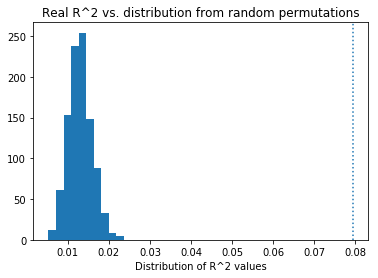

In [24]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Real R^2 vs. distribution from random permutations")

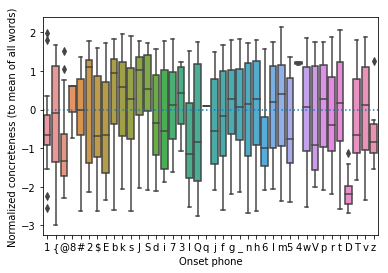

In [25]:
# Rescale
df_merged['Concreteness_normalized'] = df_merged['Concreteness'] - np.mean(df_merged['Concreteness'])

ax = sn.boxplot(data=df_merged, x="initial", y="Concreteness_normalized")
ax.set(xlabel="Onset phone", ylabel="Normalized concreteness (to mean of all words)")
ax.axhline(y=0, linestyle="dotted")

### Follow-up discussion

In the follow-up analysis, we didn't control for features about the rest of the word, and instead asked whether words that begin with particular sounds have systematic differences in their overall concreteness. (Whereas before, we asked whether the same *onset sound* has systematic *impacts* on word concreteness, once we control for the  rest of the word.)

Reassuringly, we see the same trend for **/D/**, which again has a consistent and **strong** negative impact on concreteness. We don't see the same trend for **/2/**, though it's unclear whether this is because it's a null relationship or because there are confounding factors (when we don't control for the rest of the word). Critically, the visualization above is comparing the concreteness of words beginning with a given sound to the *mean* concreteness of all words.

But we also see systematic patterns for a few others:
- Words beginning with **/@/** (e.g. the sound in *away* or *accuser*) are more likely to be **less concrete**.
- Words beginning with **/I/** (e.g. the sound in *exertion* or *exclusion*) are more likely to be **less concrete**.
- Words beginning with **/b/** (e.g. the sound in *body* or *badge*) are slightly more likely to be **more concrete**.
- Words beginning with **/J/** (e.g. *ch-* in cheek) and **/S/** (e.g. "sh" in "shovel") are more concrete.
- Words beginning with **/k/** are weakly more concrete.

In [59]:
df_merged[df_merged['initial'] == "@"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,Concreteness_normalized
2483,obedient,0.70,2,@bidj@nt,A,3,3.17,@,-1.247857
2490,obscure,0.95,1,@bskj9R,V,2,3.20,@,-1.217857
219,attend,1.88,0,@tEnd,V,2,3.24,@,-1.177857
49,admission,1.28,2,@dmISH,N,3,3.05,@,-1.367857
62,affection,1.42,2,@fEkSH,N,3,2.80,@,-1.617857


In [60]:
df_merged[df_merged['initial'] == "I"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,Concreteness_normalized
1856,infant,1.57,0,Inf@nt,N,2,5.79,I,1.372143
1259,exterior,0.48,1,Ikst7r7R,N,3,4.74,I,0.322143
1914,invitation,1.38,2,InvIt1SH,N,4,4.39,I,-0.027857
1241,excitement,1.58,2,Iks2tm@nt,N,3,2.82,I,-1.597857
1789,idiom,0.48,1,Id7m,N,2,3.60,I,-0.817857


In [26]:
df_merged[df_merged['initial'] == "b"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,Concreteness_normalized
277,barnacle,0.00,1,b#n@kP,N,3,5.42,b,0.853288
373,blessing,1.15,1,blEsIN,N,2,2.77,b,-1.796712
413,bottle,2.06,1,bQtP,N,2,5.91,b,1.343288
320,being,1.96,1,biIN,N,2,2.76,b,-1.806712
474,building,2.25,1,bIldIN,N,2,5.89,b,1.323288


In [27]:
df_merged[df_merged['initial'] == "J"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,Concreteness_normalized
628,chinchilla,0.00,1,JInJIl@,N,3,5.58,J,1.013288
619,chew,0.00,1,Ju,N,1,4.42,J,-0.146712
606,chart,1.26,1,J#t,N,1,5.32,J,0.753288
612,cheek,1.65,1,Jik,N,1,5.65,J,1.083288
616,cherry,0.85,1,JErI,N,2,6.11,J,1.543288


In [28]:
df_merged[df_merged['initial'] == "S"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial,Concreteness_normalized
603,charlatan,0.00,0,S#l@t@n,N,3,4.07,S,-0.496712
3285,shoe,1.90,1,Su,N,1,6.00,S,1.433288
3278,shield,0.90,1,Sild,N,1,5.76,S,1.193288
3296,shovel,0.60,1,SVvP,N,2,5.81,S,1.243288
3297,show,1.84,1,S5,N,1,4.02,S,-0.546712
